In [765]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

path = "/Users/crobinson1205/LearnPython/"

clinical = f"{path}clinicaltrial_data.csv"
mouse = f"{path}mouse_drug_data.csv"
#clinical= "H:\TempPython\clinicaltrial_data.csv"
#mouse = "H:\TempPython\mouse_drug_data.csv"

clinical_df = pd.read_csv(clinical)
mouse_df = pd.read_csv(mouse)

#combine both data
trialdata_df = pd.merge(clinical_df, mouse_df, how = "left", on = "Mouse ID")

In [751]:
#get mean by drug at each time point
volume_mean = trialdata_df.groupby(["Timepoint","Drug"]).agg({'Tumor Volume (mm3)': 'mean'})

#pivot volume_mean by drug time and Timepoint as row grouping
vm_pivot = pd.pivot_table(volume_mean, values = "Tumor Volume (mm3)", index = "Timepoint", columns = "Drug")
vm_pivot = vm_pivot.reset_index()

#get standard error by drug at each time point
volume_sem = trialdata_df.groupby(["Timepoint","Drug"]).agg({'Tumor Volume (mm3)': 'sem'})

#pivot volume_sem by drug time and Timepoint as row grouping
vs_pivot = pd.pivot_table(volume_sem, values = "Tumor Volume (mm3)", index = "Timepoint", columns = "Drug")
vs_pivot = vs_pivot.reset_index()

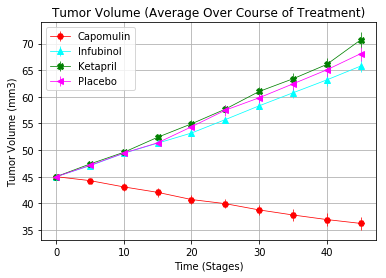

In [752]:
#Plotting Tumor Volume (with error bars) over time of treatment
plt.errorbar(vm_pivot["Timepoint"],vm_pivot["Capomulin"],vs_pivot["Capomulin"],color = "red",marker = 'H',ls = "-",linewidth = .75)
plt.errorbar(vm_pivot["Timepoint"],vm_pivot["Infubinol"],vs_pivot["Infubinol"],color = "cyan",marker = '^',ls = "-",linewidth = .75)
plt.errorbar(vm_pivot["Timepoint"],vm_pivot["Ketapril"],vs_pivot["Ketapril"],color = "green",marker = 'X',ls = "-",linewidth = .75)
plt.errorbar(vm_pivot["Timepoint"],vm_pivot["Placebo"],vs_pivot["Placebo"],color = "magenta",marker = '<',ls = "-",linewidth = .75)

#formatting
title = "Tumor Volume (Average Over Course of Treatment)"
plt.title(title)
plt.legend()
plt.xlabel("Time (Stages)")
plt.ylabel("Tumor Volume (mm3)")
plt.grid()
plt.savefig(f"{path}{title}.jpeg")

In [753]:
#merge beginning and end results of drug perforance
drug_compare_df = pd.merge(vm_pivot.iloc[0],vm_pivot.iloc[-1], on = "Drug", how = "left")

#calculate percent change
drug_compare_df["Change (%)"] = ((drug_compare_df.iloc[:,1] - drug_compare_df.iloc[:,0])/drug_compare_df.iloc[:,0])*100
drug_compare_df = drug_compare_df.reset_index()
drug_compare_df = drug_compare_df.rename(columns={0: "Start of Treatment (Size)", 9: "End of Treatment (Size)"})

drug_compare_df = drug_compare_df[(drug_compare_df['Drug']  == "Capomulin") | (drug_compare_df['Drug'] == "Infubinol") | (drug_compare_df['Drug'] == "Ketapril") | (drug_compare_df['Drug'] == "Placebo")]

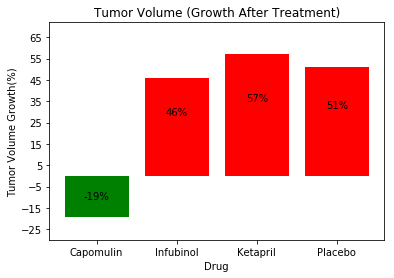

In [759]:
#logic for bar coloring
compare = drug_compare_df["Change (%)"] > 0

#boolean return mapping to color for bars
growth = {False : "green", True : "red"}

#plot bar chart
graph = plt.bar(drug_compare_df["Drug"], drug_compare_df["Change (%)"],align='center',color = (compare).map(growth))

#create x axes
x_axis = np.arange(len(list(drug_compare_df["Change (%)"])))
tick_locations_x = [value for value in x_axis]
plt.xticks(tick_locations_x, list(drug_compare_df["Drug"]))

#spacing for y ticks
plt.yticks(np.arange(-25, 75, step=10))

#function for values on bars
def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2, .6*height,
            '%d' % int(height) + "%",
            ha='center', va='bottom')

autolabel(graph)

#formatting
title = "Tumor Volume (Growth After Treatment)"
plt.title(title)
plt.ylabel("Tumor Volume Growth(%)")
plt.xlabel("Drug")
plt.ylim(-30, max(drug_compare_df["Change (%)"])+15)
plt.savefig(f"{path}{title}.jpeg")

In [764]:
#get mean of metastatic sites by drug at each time point
mean_sites = trialdata_df.groupby(["Timepoint","Drug"]).agg({'Metastatic Sites': 'mean'})

#pivot mean_sites by drug time and Timepoint as row grouping
sites_pivot = pd.pivot_table(mean_sites, values = "Metastatic Sites", index = "Timepoint", columns = "Drug")
sites_pivot = sites_pivot.reset_index()

#get standard error of metastatic sites by drug at each time point
sites_sem = trialdata_df.groupby(["Timepoint","Drug"]).agg({'Metastatic Sites': 'sem'})

#pivot site_sem by drug time and Timepoint as row grouping
sitesem_pivot = pd.pivot_table(sites_sem, values = "Metastatic Sites", index = "Timepoint", columns = "Drug")
sitesem_pivot = sitesem_pivot.reset_index()

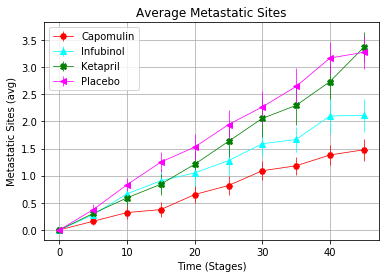

In [756]:
#Plotting average Metastatic Sites (with error bars) over time of treatment
plt.errorbar(sites_pivot["Timepoint"],sites_pivot["Capomulin"],sitesem_pivot["Capomulin"],color = "red",marker = 'H',ls = "-",linewidth = .75)
plt.errorbar(sites_pivot["Timepoint"],sites_pivot["Infubinol"],sitesem_pivot["Infubinol"],color = "cyan",marker = '^',ls = "-",linewidth = .75)
plt.errorbar(sites_pivot["Timepoint"],sites_pivot["Ketapril"],sitesem_pivot["Ketapril"],color = "green",marker = 'X',ls = "-",linewidth = .75)
plt.errorbar(sites_pivot["Timepoint"],sites_pivot["Placebo"],sitesem_pivot["Placebo"],color = "magenta",marker = '<',ls = "-",linewidth = .75)

#formatting
title = "Average Metastatic Sites"
plt.title(title)
plt.legend()
plt.xlabel("Time (Stages)")
plt.ylabel("Metastatic Sites (avg)")
plt.grid()
plt.savefig(f"{path}{title}.jpeg")

In [763]:
#use Tumor Volume column as marker of survival via count
mice_count = trialdata_df.groupby(["Mouse ID","Timepoint"]).agg({'Tumor Volume (mm3)': 'count'})

#pivot results for easier formatting
mice_pivot = pd.pivot_table(mice_count,values = "Tumor Volume (mm3)", index = "Mouse ID",  columns = "Timepoint")

#replacing n/a with 0 so values can be added
mice_pivot = mice_pivot.fillna(0)

#adding drug to table
mice_pivot = pd.merge(mice_pivot, mouse_df[["Mouse ID","Drug"]], on = "Mouse ID", how = "left")

del mice_pivot["Mouse ID"]

#aggregating values by timepoint
mice_pivot = mice_pivot.groupby("Drug").agg({0: 'sum',5: 'sum',10: 'sum',15: 'sum',20: 'sum',25: 'sum',30: 'sum', 35: 'sum', 40: 'sum', 45: 'sum'})
mice_pivot = mice_pivot.reset_index()

#del mice_survived
mice_survived = pd.DataFrame()
mice_survived["Drug"] = mice_pivot.iloc[:,0]

#manually transposing values to get drug names as column titles and timepoints as row names
for x in range(1,len(list(mice_pivot.columns))):
    mice_survived[list(mice_pivot.columns)[x]] = (mice_pivot.iloc[:,x]/mice_pivot.iloc[:,1])*100
mice_survived = mice_survived.set_index([list(mice_survived.columns)[1:]]).T
mice_survived = mice_survived.drop(["Drug"])

for x in range(0,len(list(mice_survived.columns))):
    mice_survived = mice_survived.rename(columns={list(mice_survived.columns)[x]:list(mice_pivot.iloc[:,0])[x]}) 

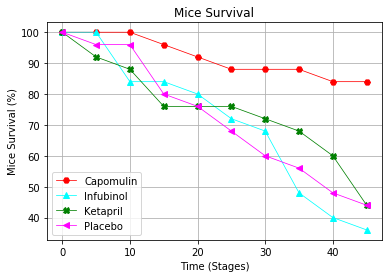

In [758]:
#Plotting % of mice alive(with error bars) over time of treatment for each drug
plt.plot(mice_survived.index,mice_survived["Capomulin"],color = "red",marker = 'H',ls = "-",linewidth = .75)
plt.plot(mice_survived.index,mice_survived["Infubinol"],color = "cyan",marker = '^',ls = "-",linewidth = .75)
plt.plot(mice_survived.index,mice_survived["Ketapril"],color = "green",marker = 'X',ls = "-",linewidth = .75)
plt.plot(mice_survived.index,mice_survived["Placebo"],color = "magenta",marker = '<',ls = "-",linewidth = .75)

#formatting
title = "Mice Survival"
plt.title(title)
plt.legend()
plt.xlabel("Time (Stages)")
plt.ylabel("Mice Survival (%)")
plt.grid()
plt.savefig(f"{path}{title}.jpeg")